## Model Training

Transformers will be used to train the Machine Learning Model. It is possible due to complexity that this notebook will be trained in Google Colab and later download to this repo.



In [1]:
import pandas as pd
import numpy as np
import os
from datasets import load_dataset, Features, ClassLabel, Value
dir_root = os.getcwd()
dir_root

C:\ProgramData\Anaconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\\Users\\entea\\CodeProjects\\clasificaion_robos_fge'

We will be using Hugging Face load rutines in order to load data and processed it. There is somehow some things that I feel like a bit lost, because in some of the examples that I have checked on huggnif faces they are not using one hot encoding. In the end we have to build a multiclass clasification and the doubt I have is if I should use the one hot variables or should only use the hagging face. If this does not work I will have to test how the Youtube video stored the tensors in numpy format, hoping that all tokenization will be able to be run

In [2]:
dataset_df = pd.read_csv(os.path.join(dir_root, 'data/interim/trainset.csv'), converters={'NDD':str})
dataset_df.sample(5)

,index,ndd,relato,cantidadPalabras,tipoDelitoPj,target,labelsRoboADomicilio,labelsRoboAPersonas,labelsRoboAUnidadesEconomicas,"labelsRoboDeBienes,AccesoriosYAutopartesDeVehiculos",labelsRoboDeCarros,labelsRoboDeMotos,labels
216932,303326,170101815063467,es el caso señor fiscal que en el dia y la hor...,60,ROBO,5,1,0,0,0,0,0,ROBO A DOMICILIO
268713,128316,90101817094965,es el caso señor fiscal que el día 20 de septi...,89,ROBO,6,0,1,0,0,0,0,ROBO A PERSONAS
157147,64012,80101821120123,sucede señor fiscal que día viernes 03 de dici...,99,ROBO,6,0,1,0,0,0,0,ROBO A PERSONAS
28015,168403,90101820104135,es el caso señor fiscal que el dia 4 de octubr...,91,ROBO,6,0,1,0,0,0,0,ROBO A PERSONAS
126101,223229,100101816030243,es el caso señor fiscal que el día y hora ates...,96,ROBO,5,1,0,0,0,0,0,ROBO A DOMICILIO


In [3]:
labels_set = set(dataset_df.labels.to_list())

In [4]:
traincsv = os.path.join(dir_root, 'data/interim/trainsethugf.csv')
testcsv = os.path.join(dir_root, 'data/interim/testsethugf.csv')
validcsv = os.path.join(dir_root, 'data/interim/validsethugf.csv')
# class_names = ["RoboADomicilio", "RoboAPersonas", "RoboAUnidadesEconomicas", "RoboDeBienesAccesoriosYAutoPartes", "RoboDeCarros", "RoboDeMotos"]
class_names = list(labels_set)
robo_features = Features({'relato': Value('string'), 'labels': ClassLabel(names=class_names)})
dataset = load_dataset("csv", data_files={'train': traincsv, 'test': testcsv, 'validation':validcsv}, features=robo_features)

Using custom data configuration default-ba64d498e9ef90c9


Extracting data files: 100%|████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 606.99it/s]


Dataset csv downloaded and prepared to C:\Users\entea\.cache\huggingface\datasets\csv\default-ba64d498e9ef90c9\0.0.0\51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 61.09it/s]


In [5]:
dataset['train'][0]

{'relato': 'es el caso señor fiscal que el día 22 de octubre del 2014 a las 20h40 aproximadamente en circunstancias en que deje estacionado mi camioneta de placas gmd0996 color blanco marca chevrolet de mi propiedad en la dirección antes mencionada al momento de ir por ella me encuentro con la novedad que no estaba se la habían robado en el interior de la camioneta ahí una arma de fuego revolver calibre 38 de fabricación nacional que pertenece a compañía armiled por lo expuesto señor fiscal solicito que se realicen las respectivas investigaciones es justicia',
 'labels': 5}

In [6]:
seqlen = dataset_df.relato.apply(lambda x: len(x.split()))

Let us create an Histogram of the word count in Crime report

C:\ProgramData\Anaconda3\envs\tfenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='relato', ylabel='Density'>

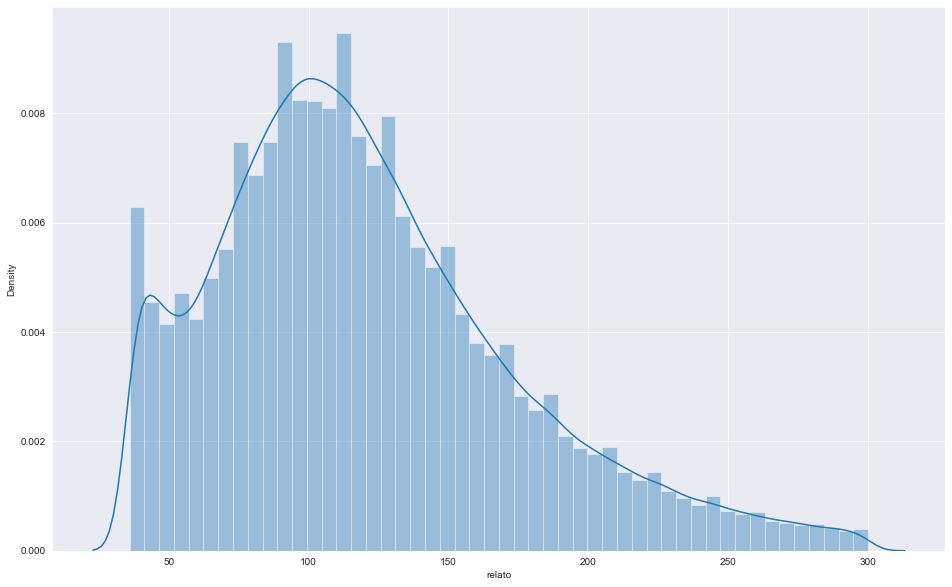

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(16,10))
sns.distplot(seqlen)

In a example solved in https://www.youtube.com/watch?v=GYDFBfx8Ts8&t=498s, the length of the sequence was set to the maximum span of the distplot. This would imply to use a length sequence of 300. I think padding and trucate are used in consequence with this size so that all tensors in would have the same length. I think that if we chouse $SEQ_LEN<200$, those reports with values below 200 will be truncated (This is something that I need to understand when writing the paper). Now by choosing to use the maximum length, which appears to be somehow 300, there should be no truncation but padding to some of the records. Let us consider what is the maximum length of the Crime report

In [8]:
seqlen.max()

300

In [9]:
dataset_df.cantidadPalabras.max()

300

We have already separated the original dataset in Train and Test. Because of that, we would split this train dataset in train and validation. Test set will be used at the end in order to proof the concept

In [10]:
dataset_df.columns

Index(['index', 'ndd', 'relato', 'cantidadPalabras', 'tipoDelitoPj', 'target',
       'labelsRoboADomicilio', 'labelsRoboAPersonas',
       'labelsRoboAUnidadesEconomicas',
       'labelsRoboDeBienes,AccesoriosYAutopartesDeVehiculos',
       'labelsRoboDeCarros', 'labelsRoboDeMotos', 'labels'],
      dtype='object')

In [11]:
# X_set = dataset_df.RELATO.to_list()
# Y_set = dataset_df[['LABELS_ROBO A DOMICILIO', 
# 'LABELS_ROBO A PERSONAS',
# 'LABELS_ROBO A UNIDADES ECONOMICAS',
# 'LABELS_ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS',
# 'LABELS_ROBO DE CARROS',
# 'LABELS_ROBO DE MOTOS']].to_numpy()

In [12]:
# X_set.iloc[0,:], Y_set.iloc[0,:]

In [13]:
# dataset_df.head()

In [14]:
# Y_set[:5,:]

In [15]:
# X_set[:5]

In [16]:
# len(X_set), Y_set.shape

Since the classification is of type Multicategorical, it is clear that:

$\mathbf{y} \in\mathcal{R}^6   $ corresponds to the labels of our set. The structure of $ \mathbf{X} $ will depend on the tokenization process. 

Moreover there are possible two ways to test.

1. The provided guide at https://huggingface.co/transformers/v3.2.0/custom_datasets.html, does not use attention masks. We could test first this approach.
2. We could follow the lead of https://www.youtube.com/watch?v=GYDFBfx8Ts8&t=498s, and provide both input_ids and masks_ids
3. We should compare how things go provided the classical approach by using count of words (wordvec, bag of words and others) And compare results.
4. There is something that is not being considered in this approach and it is unbalanced data. We should think about a way of balancing data

<AxesSubplot:>

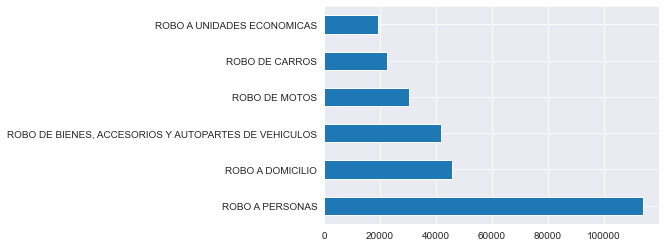

In [17]:
dataset_df.labels.value_counts().plot.barh()

I think and interesting way of solving could by making an ensemble by distributing different samples in each **weak** learner. Eventhough it is not a weak learner because they are actually transformer-convnet based learners. 

Also, it must be noticed that we are going through fine tuning a pre-trained bert model. What would happen if we train it from scratch? would it be better?

In [18]:
from transformers import DistilBertTokenizer, AutoTokenizer, DistilBertTokenizerFast
# model_name = 'xlm-roberta-large'
# model_name = 'bert-base-cased'
# model_name = 'bert-base-multilingual-uncased-sentiment'
model_name = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

Testing tokenizer with any kind of content

In [19]:
tokenizer('el CASTELLANO es una LENGUA muerta')

{'input_ids': [101, 10125, 92923, 29833, 82834, 41275, 11403, 10196, 10153, 84977, 34065, 12022, 10738, 12361, 43861, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
def tokenizer_func(examples):
  return tokenizer(examples["relato"],
                   max_length=seqlen.max(),
                   padding = "max_length",
                   truncation=True)

tokenized_dataset = dataset.map(tokenizer_func, batched=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:12<00:00,  5.71ba/s]


In [21]:
len(tokenized_dataset['validation'][-1]['input_ids']), tokenized_dataset['validation'][-1]['labels']

(300, 2)

In [22]:
tokenized_dataset['train'][0]

{'relato': 'es el caso señor fiscal que el día 22 de octubre del 2014 a las 20h40 aproximadamente en circunstancias en que deje estacionado mi camioneta de placas gmd0996 color blanco marca chevrolet de mi propiedad en la dirección antes mencionada al momento de ir por ella me encuentro con la novedad que no estaba se la habían robado en el interior de la camioneta ahí una arma de fuego revolver calibre 38 de fabricación nacional que pertenece a compañía armiled por lo expuesto señor fiscal solicito que se realicen las respectivas investigaciones es justicia',
 'labels': 5,
 'input_ids': [101,
  10196,
  10125,
  13101,
  47599,
  43645,
  10121,
  10125,
  14184,
  10306,
  10104,
  14082,
  10127,
  10194,
  169,
  10285,
  10197,
  10237,
  38109,
  21278,
  10110,
  109050,
  10110,
  10121,
  10104,
  10381,
  11504,
  57416,
  12132,
  88406,
  17670,
  10213,
  10104,
  93697,
  175,
  37527,
  10929,
  88657,
  11211,
  14136,
  34488,
  13534,
  10262,
  99959,
  12630,
  1010

In [23]:
import tensorflow as tf
tf.__version__

'2.6.0'

Following what is proposed in: https://huggingface.co/docs/transformers/tasks/sequence_classification

In [24]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [25]:
tokenized_dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [26]:
# tf_train_set = tokenized_dataset["train"].to_tf_dataset(
#     columns=["attention_mask", "input_ids", "labels"],
#     shuffle=True,
#     batch_size=16,
#     collate_fn=data_collator,
# )

# tf_validation_set = tokenized_dataset["validation"].to_tf_dataset(
#     columns=["attention_mask", "input_ids", "labels"],
#     shuffle=False,
#     batch_size=16,
#     collate_fn=data_collator,
# )

In [123]:
# lowering samples to proof concept again
tf_train_set = tokenized_dataset["train"].shuffle(seed=42).select(range(20000)).to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_dataset["validation"].shuffle(seed=42).select(range(4000)).to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [152]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 50
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [153]:
total_train_steps

854150

TFDistilBert has a weight of 869 MGBytes

In [154]:
from transformers import TFAutoModelForSequenceClassification, TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=6)

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['dropout_99', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream ta

In [155]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  134734080 
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  4614      
_________________________________________________________________
dropout_99 (Dropout)         multiple                  0         
Total params: 135,329,286
Trainable params: 135,329,286
Non-trainable params: 0
_________________________________________________________________


In [156]:
model.layers[0].trainable = False
mse = tf.keras.metrics.mse
acc = tf.keras.metrics.categorical_accuracy
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# model.compile(optimizer=optimizer, metrics = ['accuracy', 'AUC', 'Precision', 'Recall'])
model.compile(optimizer=optimizer, metrics = ['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [157]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  134734080 
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  4614      
_________________________________________________________________
dropout_99 (Dropout)         multiple                  0         
Total params: 135,329,286
Trainable params: 595,206
Non-trainable params: 134,734,080
_________________________________________________________________


In [158]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [159]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [160]:
history = model.fit(tf_train_set, validation_data=tf_validation_set, epochs=num_epochs, callbacks = [callback])

Epoch 1/50
1250/1250 [==============================] - 378s 296ms/step - loss: 1.5806 - accuracy: 0.4168 - val_loss: 1.5456 - val_accuracy: 0.4193
Epoch 2/50
1250/1250 [==============================] - 355s 284ms/step - loss: 1.5344 - accuracy: 0.4176 - val_loss: 1.4990 - val_accuracy: 0.4195
Epoch 3/50
1250/1250 [==============================] - 357s 286ms/step - loss: 1.4896 - accuracy: 0.4198 - val_loss: 1.4511 - val_accuracy: 0.4218
Epoch 4/50
1250/1250 [==============================] - 357s 286ms/step - loss: 1.4418 - accuracy: 0.4305 - val_loss: 1.4021 - val_accuracy: 0.4415
Epoch 5/50
1250/1250 [==============================] - 356s 285ms/step - loss: 1.3975 - accuracy: 0.4496 - val_loss: 1.3610 - val_accuracy: 0.4442
Epoch 6/50
1250/1250 [==============================] - 357s 285ms/step - loss: 1.3546 - accuracy: 0.4779 - val_loss: 1.3129 - val_accuracy: 0.4830
Epoch 7/50
1250/1250 [==============================] - 355s 284ms/step - loss: 1.3151 - accuracy: 0.5042 - val_

In [161]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

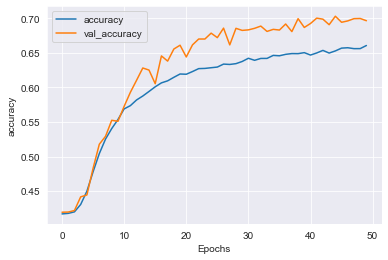

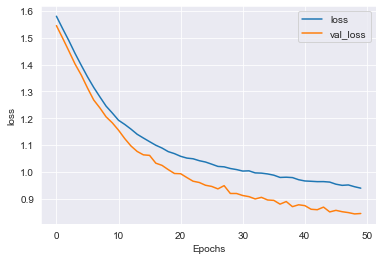

In [162]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Saving MOdel

In [231]:
tfmodel = tf.saved_model.save(model, os.path.join(dir_root, 'models/tfsample'))

INFO:tensorflow:Assets written to: C:\Users\entea\CodeProjects\clasificaion_robos_fge\models/tfsample\assets


INFO:tensorflow:Assets written to: C:\Users\entea\CodeProjects\clasificaion_robos_fge\models/tfsample\assets


## Evaluating the model

In [259]:
tf_test_set = tokenized_dataset["test"].shuffle(seed=42).select(range(4000)).to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [260]:
import tensorflow_datasets as tfds
tfds.__version__

'4.2.0'

In [261]:
test_npy = tfds.as_numpy(tf_test_set)
# for count, i in enumerate(test_npy):
#     print(count, i)

In [262]:
type(test_npy)

tensorflow_datasets.core.dataset_utils._IterableDataset

The next code brings the last batch of 16 values

In [263]:
for batch in test_npy:
    y_true = batch['labels']
y_true

array([2, 2, 2, 0, 0, 1, 4, 2, 2, 2, 3, 2, 1, 4, 3, 0], dtype=int64)

In [264]:
iterable = list(batch['labels'] for batch in test_npy)
y_true = np.hstack(iterable)

In [265]:
y_true.shape


(4000,)

In [266]:
y_true[:64]

array([2, 4, 2, 2, 4, 2, 4, 1, 1, 5, 0, 1, 2, 2, 2, 0, 5, 4, 2, 1, 5, 2,
       4, 1, 0, 1, 5, 1, 1, 1, 0, 5, 4, 2, 0, 2, 5, 2, 2, 4, 2, 1, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 0, 4, 5, 0, 2, 3, 2, 4, 4, 0, 0, 5],
      dtype=int64)

In [267]:
for batch, datay in enumerate(test_npy):
    if batch < 4:
        print(datay['labels'])
    

[2 4 2 2 4 2 4 1 1 5 0 1 2 2 2 0]
[5 4 2 1 5 2 4 1 0 1 5 1 1 1 0 5]
[4 2 0 2 5 2 2 4 2 1 2 2 2 3 2 2]
[2 2 2 2 0 4 5 0 2 3 2 4 4 0 0 5]


In [268]:
model.evaluate(tf_test_set)

250/250 [==============================] - 215s 859ms/step - loss: 0.8375 - accuracy: 0.6963


[0.8375054597854614, 0.6962500214576721]

In [269]:
model.predict(tf_test_set)['logits'][:10]

array([[-1.8938175 , -2.1939156 ,  2.925122  , -1.7627414 , -1.834776  ,
        -0.6377455 ],
       [-1.0203629 , -3.2478042 , -0.10727154, -4.065733  ,  3.9629953 ,
         1.4146681 ],
       [-0.6854983 ,  0.02302741,  2.0864737 , -0.28316516, -3.0705626 ,
        -3.091279  ],
       [ 1.0274847 ,  0.6650103 ,  0.55600816,  1.06282   , -5.4617968 ,
        -2.2463362 ],
       [ 0.9113807 , -3.2087286 , -1.4631687 , -3.8724406 ,  3.598364  ,
         1.2057283 ],
       [-1.4130967 , -0.6984066 ,  2.2539847 , -1.2146883 , -1.9784672 ,
        -2.204728  ],
       [ 0.527215  , -3.019473  , -0.82465166, -3.7583344 ,  2.7364314 ,
         1.3016833 ],
       [-0.7664279 ,  1.5248843 ,  1.9501929 ,  0.94480455, -4.1714478 ,
        -4.392328  ],
       [-1.0829346 ,  2.10998   ,  0.25024453,  0.2803523 , -1.8690137 ,
        -3.6745164 ],
       [-0.3370742 , -0.9370362 ,  2.197501  ,  0.00854473, -3.077041  ,
        -2.0904438 ]], dtype=float32)

The next code will get the probabilities using softmax

In [270]:
y_logits = model.predict(tf_test_set).logits
yprob = tf.nn.softmax(y_logits, axis=1).numpy()
yprob[:10]

array([[7.6169032e-03, 5.6421887e-03, 9.4322950e-01, 8.6836880e-03,
        8.0801584e-03, 2.6747528e-02],
       [6.2101255e-03, 6.6947623e-04, 1.5475727e-02, 2.9546971e-04,
        9.0645331e-01, 7.0895880e-02],
       [4.8312183e-02, 9.8121770e-02, 7.7251822e-01, 7.2241649e-02,
        4.4487333e-03, 4.3575205e-03],
       [2.9451782e-01, 2.0497030e-01, 1.8380269e-01, 3.0511072e-01,
        4.4756124e-04, 1.1150881e-02],
       [5.8318503e-02, 9.4725221e-04, 5.4269093e-03, 4.8777455e-04,
        8.5654151e-01, 7.8278035e-02],
       [2.2511482e-02, 4.6003416e-02, 8.8104337e-01, 2.7451860e-02,
        1.2789889e-02, 1.0200067e-02],
       [7.9495318e-02, 2.2910503e-03, 2.0569954e-02, 1.0943371e-03,
        7.2408915e-01, 1.7246020e-01],
       [3.1632930e-02, 3.1278342e-01, 4.7857815e-01, 1.7511293e-01,
        1.0504082e-03, 8.4223086e-04],
       [2.9769031e-02, 7.2515351e-01, 1.1291641e-01, 1.1636777e-01,
        1.3563597e-02, 2.2297448e-03],
       [6.3248985e-02, 3.4713097e-02,

In [271]:
yhat = tf.argmax(yprob, axis=1)
# yhat = tf.argmax(yprob, 1)
yhat[:64]

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([2, 4, 2, 3, 4, 2, 4, 2, 1, 2, 0, 1, 2, 2, 2, 0, 5, 4, 2, 2, 4, 2,
       4, 2, 0, 1, 2, 1, 1, 3, 0, 4, 2, 2, 2, 2, 0, 2, 1, 4, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 4, 2, 2, 2, 2, 2, 4, 2, 0, 5],
      dtype=int64)>

In [272]:
yhat_onehot = tf.one_hot(yhat, depth=6, dtype=tf.float32)
yhat_onehot[:20]

<tf.Tensor: shape=(20, 6), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)>

In order to compute any type of metrics using sklearn or other library, it is necessary to contrast ground truth with predicted values. Because of that, we can see that the test tensorflow set contains numbered labels. According to the link: https://analyticsindiamag.com/step-by-step-guide-to-implement-multi-class-classification-with-bert-tensorflow/ the following code is tried to get the one-hot encoding

In [273]:
ytrue_onehot = tf.one_hot(y_true, depth=6, dtype=tf.float32)
y_true[:10], ytrue_onehot[:10]

(array([2, 4, 2, 2, 4, 2, 4, 1, 1, 5], dtype=int64),
 <tf.Tensor: shape=(10, 6), dtype=float32, numpy=
 array([[0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32)>)

In [274]:
from sklearn.metrics import  classification_report
print(classification_report(y_true=ytrue_onehot, y_pred=yhat_onehot))

              precision    recall  f1-score   support

           0       0.68      0.63      0.66       613
           1       0.69      0.57      0.63       651
           2       0.67      0.93      0.78      1666
           3       0.60      0.09      0.15       285
           4       0.87      0.69      0.77       457
           5       0.84      0.42      0.56       328

   micro avg       0.70      0.70      0.70      4000
   macro avg       0.72      0.55      0.59      4000
weighted avg       0.70      0.70      0.67      4000
 samples avg       0.70      0.70      0.70      4000



In [275]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true=ytrue_onehot, y_pred=yhat_onehot)

array([[[3208,  179],
        [ 227,  386]],

       [[3179,  170],
        [ 277,  374]],

       [[1557,  777],
        [ 119, 1547]],

       [[3698,   17],
        [ 260,   25]],

       [[3497,   46],
        [ 141,  316]],

       [[3646,   26],
        [ 191,  137]]], dtype=int64)

In [276]:
tf.math.confusion_matrix(y_true, yhat, 6).numpy()

array([[ 386,   20,  184,    3,    8,   12],
       [  27,  374,  243,    6,    1,    0],
       [  26,   58, 1547,    5,   25,    5],
       [  23,   83,  153,   25,    1,    0],
       [  15,    3,  113,    1,  316,    9],
       [  88,    6,   84,    2,   11,  137]])

In [277]:
tf.metrics.categorical_accuracy(y_true=ytrue_onehot, y_pred=yhat_onehot).numpy()

array([1., 1., 1., ..., 1., 0., 1.], dtype=float32)

In [278]:
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(model, tf_test_set, y_true)

In [279]:
model.save('models/modeltf',save_format='tf')

INFO:tensorflow:Assets written to: models/modeltf\assets


INFO:tensorflow:Assets written to: models/modeltf\assets


In [280]:
model.save_pretrained('models/huggingfacemodel')

In [285]:
tokenizer.save_pretrained("/models/tokenizer/")

('/models/tokenizer/tokenizer_config.json',
 '/models/tokenizer/special_tokens_map.json',
 '/models/tokenizer/vocab.txt',
 '/models/tokenizer/added_tokens.json',
 '/models/tokenizer/tokenizer.json')

In order to have a tensorflow model it is necessary to save the weights and thenn create the model and load the weights back. this 

In [282]:
model.save_weights('models/modelweights/modelweights')

In [284]:
# model.save_model("models/fullmodel")